# Hamming网

## 简介

Hamming网使用汉明距离度量两个向量的距离。

汉明距离衡量的是两个相同长度向量对应位不同的数量，因此Hamming网仅能处理有限个离散值输入向量的模式识别问题。

Hamming网通过递归竞争判定输入向量最接近哪一个记忆的向量，实现对输入向量的模式识别。

对于一个特定的输入，Hamming网络收敛后仅有一个神经元的输出为非0值，该输出表示输入与该神经元记忆的向量最为相似。

## 符号定义

|符号|含义|
|:-:|:-:|
|$\bm{X}$|输入向量|
|$n$|输入向量维度|
|$\bm{a}$|前馈层输出|
|$\bm{W}$|前馈层权矩阵|
|$\bm{b}$|前馈层偏置|
|$f$|前馈层激活函数|
|$c$|前馈层神经元数量(网络记忆的模式总数)|
|$\bm{V}$|递归层权矩阵|
|$\bm{\hat{y}}$|递归层输出|
|$\bm{y}$|真实输出|
|$\bm{r_i}$|网络记忆的第i个向量|

## Hamming网的正向计算

### 前馈层

$$
\begin{equation}
    \bm{X} = [x_1, x_2, \cdots, x_n]^T, \ x_i\in\{-1, 1\}, i=1, 2, 3, \cdots, n
\end{equation}
$$

$$
\begin{equation}
    \bm{a} = f(\bm{W}\bm{X}+\bm{b})
\end{equation}
$$

$$
\begin{equation}
    f(x) = 
    \left\{
    \begin{array}{cc}
    x,&x\geq0 \\
    0,&x<0
    \end{array}
    \right.
\end{equation}
$$

### 递归层

$$
\begin{equation}
    \left\{
    \begin{array}{cc}
    \bm{\hat{y}}(0) = \bm{a} \\
    \bm{\hat{y}}(t+1) = f(\bm{V}\bm{\hat{y}}(t))
    \end{array}
    \right.
\end{equation}
$$


当递归层的输出$\bm{\hat{y}}(t+1)$仅有一个数为非0数时递归结束

## Hamming网的权重设计与学习

### 权重设计

* 前馈层权重
$$
\begin{equation}
    \bm{W} = 
    \left[
        \begin{array}{cc}
            \bm{r_1}^T \\
            \bm{r_2}^T \\
            \vdots \\
            \bm{r_c}^T \\
        \end{array}
    \right]
\end{equation}
$$

* 前馈层偏置
$$
\begin{equation}
    \bm{b} = [n, n, \cdots, n]^T
\end{equation}
$$

* 递归层权重
$$
\begin{equation}
    \bm{V} = 
    \left[
        \begin{array}{cc}
            1&-\epsilon&\cdots&-\epsilon \\
            -\epsilon&1&\cdots&-\epsilon \\
            \vdots&\ddots&\ddots&\vdots\\
            -\epsilon&-\epsilon&\cdots&1
        \end{array}
    \right] , \ 
    \epsilon \in (0, \frac{1}{c})
\end{equation}
$$

可以看到，上述的权重设计中，递归层对自身的反馈是正反馈，而对其他神经元的反馈是抑制的。这体现了Hamming网的思路：**竞争性**

### 权重学习

递归层的权重无需改变，仅需要改变前馈层的权重

对于待记忆的模式向量$\bm{r_i}$,其期望输出为$[0, 0, \cdots, 1, \cdots, 0]^T$，其中第i位为非零值

因此，对于前馈层的输出，应当第i位的输出尽可能大，其他位的输出尽可能小

由此可以得到对于待记忆的模式向量$\bm{r_i}$，有下式的权重更新方法
$$
\begin{equation}
    \bm{W} = \bm{W} + [0, 0, \cdots, 1, \cdots, 0]^T\bm{r_i}^T
\end{equation}
$$
通过上式可以得到如下的参数学习伪代码
```
# 定义迭代次数
def iteration
# 定义待记忆模式向量
def r_1
def r_2
...
def r_c
# 定义权重矩阵
def W
# 定义偏置
def b

# 迭代开始
# 遍历所有待记忆的向量
for r_i in [r_1, r_2, ..., r_c]
    while True
        if argmax(W@r_i+b) == i
            break
        else
            # 生成mask向量
            mask_vector = zeros((c, 1))
            mask_vector[i] = 1
            W = W + mask_vector @ r_i.T

        iter += 1
        if iter == iteration:
            break
```
权重学习没有太大的意义，对于Hamming网来说，设计得到的权重在归一化的情况下基本上可以认为是最优权重。

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [40]:
class HammingNN(object):

    def __init__(self, input_dim, output_dim, max_iters):
        """
        input_dim: 输入维度
        output_dim: 输出维度，也是总记忆向量的数量
        max_iters: 递归层最大递归次数
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.max_iters = max_iters

        self.forward_weight = np.zeros((output_dim, input_dim+1))
        self.recursive_weight = np.ones((output_dim, output_dim))
    
    def forward(self, input_vector):

        # 前馈层
        input_vector_expend = np.concatenate((input_vector, [[1]]), axis=0)
        self.forward_output = self.activate_func(np.matmul(self.forward_weight, input_vector_expend))
        # 递归层
        pred_vector = self.forward_output
        pred_vector_list = [pred_vector]
        for _ in range(self.max_iters):

            if np.sum(pred_vector > 0) == 1:
                break
            else:
                pred_vector = self.activate_func(np.matmul(self.recursive_weight, pred_vector))
                pred_vector_list.append(pred_vector)
        
        return pred_vector, np.array(pred_vector_list)
    
    def weight_design(self, standard_vectors):
        """
        standard_vectors : 待记忆向量列表
        """
        assert len(standard_vectors) == self.output_dim

        # 前馈层的权重设计
        for i, standard_vector in enumerate(standard_vectors):
            self.forward_weight[i] = np.append(np.array(standard_vector).reshape(-1), self.input_dim)
        # 递归层的权重设计
        self.recursive_weight = -np.ones((self.output_dim, self.output_dim)) / self.output_dim
        self.recursive_weight += np.diag(np.ones(self.output_dim)+ 1 / self.output_dim)

        print("weight design done...")
    
    def weight_learning(self, standard_vectors):
        pass
    
    @staticmethod
    def activate_func(input_vector):
        mask_ = np.array(input_vector) > 0
        return input_vector * mask_.astype(np.int32)
        

weight design done...


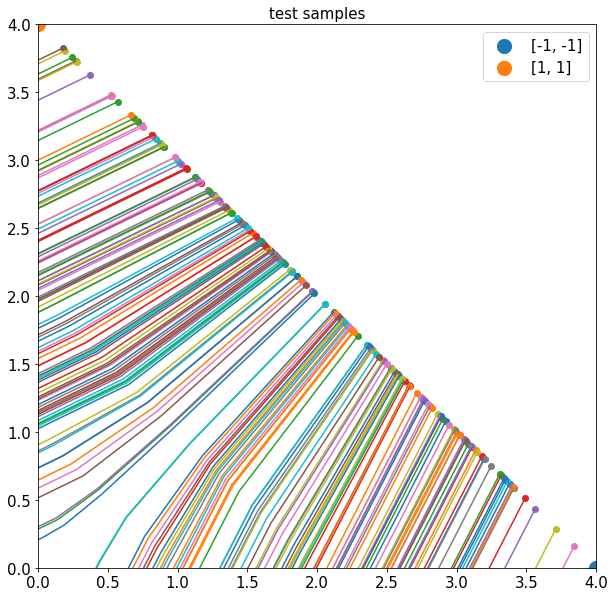

In [62]:
# 测试

# 假设标准向量为[-1, -1], [1, 1]
standard_vectors = [[-1, -1], [1, 1]]
# 定义模型
hammingNN = HammingNN(input_dim=2, output_dim=2, max_iters=10)
# 权重设计
hammingNN.weight_design(standard_vectors)

# 测试输入
# 测试输入由[-1, 1]随机取的100个点组成
test_data = list()
trace_list = list()
random.seed(1024)
for i in range(200):
    test_data.append([random.random()*2-1, random.random()*2-1])
test_data.append([-1, -1])
test_data.append([1, 1])

plt.figure(figsize=(10, 10))
plt.title("test samples", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 4)
plt.ylim(0, 4)
for test_sample in test_data:
    _, pred_list = hammingNN.forward(np.array(test_sample).reshape(-1, 1))
    if test_sample == [-1, -1] or test_sample == [1, 1]:
        plt.scatter(pred_list[0][0], pred_list[0][1], label="{}".format(test_sample), s=200)
        plt.plot(pred_list[:, 0], pred_list[:, 1])
    else:
        plt.scatter(pred_list[0][0], pred_list[0][1])
        plt.plot(pred_list[:, 0], pred_list[:, 1])

plt.legend(fontsize=15)
plt.show()

可以看到，所有的样本点均收敛到了[c, 0]或是[0, c]。收敛有明显的分界点，并且作为待记忆向量的输入经过前向计算后位于坐标轴上